# DB 종료 후 DF 작업하기
(여기서부터 시작)

In [75]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
# from sqlalchemy import create_engine
# !pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
import os

In [76]:
# matplotlib 한글 사용

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

### 데이터 불러와서 가공하기

In [77]:
wt_df = pd.read_csv('./data/weather_data.csv')
wt_df.columns

Index(['Unnamed: 0', 'station_id', 'station_name', 'date_time', 'avg_temp',
       'min_temp', 'max_temp', 'daily_precipitation', 'avg_wind_speed',
       'daily_snow_depth'],
      dtype='object')

In [78]:
# 필요 컬럼만 자르기
wt_df = wt_df.loc[:, ['date_time', 'avg_temp', 'min_temp', 'max_temp']]
wt_df.columns=['date', 'avg_temp', 'min_temp', 'max_temp']
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1399 non-null   object 
 1   avg_temp  1399 non-null   float64
 2   min_temp  1398 non-null   float64
 3   max_temp  1399 non-null   float64
dtypes: float64(3), object(1)
memory usage: 43.8+ KB


### 날짜를 기준으로 년, 계절, 평일/주말(+공휴일) 나누기

df의 date의 타입 변경

In [79]:
wt_df['date'] = pd.to_datetime(wt_df['date'])
wt_df.info() # date타입이 datetime64[ns]으로 변경됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1399 non-null   datetime64[ns]
 1   avg_temp  1399 non-null   float64       
 2   min_temp  1398 non-null   float64       
 3   max_temp  1399 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 43.8 KB


In [80]:
# fine_dust["date"]에 따라 평일, 주말 나누기(월~금 : 0~4, 토일 : 5, 6)
wt_df["day"] = np.where(wt_df["date"].dt.weekday < 5, "Weekday", "Weekend")
wt_df


,date,avg_temp,min_temp,max_temp,day
0,2021-01-01,-4.2,-9.8,1.6,Weekday
1,2021-01-02,-5.0,-8.4,-1.4,Weekend
2,2021-01-03,-5.6,-9.1,-2.0,Weekend
3,2021-01-04,-3.5,-8.4,0.3,Weekday
4,2021-01-05,-5.5,-9.9,-2.1,Weekday
...,...,...,...,...,...
1394,2024-10-26,17.0,10.7,24.0,Weekend
1395,2024-10-27,16.0,14.0,18.8,Weekend
1396,2024-10-28,15.7,12.3,20.4,Weekday
1397,2024-10-29,15.0,13.4,18.3,Weekday


공휴일 데이터인 hd의 date의 타입 변경

In [81]:
hd = pd.read_csv('./data/hd_21_24.csv', encoding="CP949")
hd.rename(columns={"일시":"date"}, inplace=True)
hd['date'] = pd.to_datetime(hd['date'])
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      66 non-null     datetime64[ns]
 1   dateName  66 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.2+ KB


fine_dust['day_type'] 만들어서 평일/주말+공휴일로 나누기 (공휴일은 주말로 처리)

In [82]:
# df와 hd DF 합치기
m_df = pd.merge(wt_df, hd, how='outer', on='date')
m_df.info(), m_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1400 non-null   datetime64[ns]
 1   avg_temp  1399 non-null   float64       
 2   min_temp  1398 non-null   float64       
 3   max_temp  1399 non-null   float64       
 4   day       1399 non-null   object        
 5   dateName  66 non-null     object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 65.8+ KB


(None,
            date  avg_temp  min_temp  max_temp      day dateName
 1395 2024-10-27      16.0      14.0      18.8  Weekend      NaN
 1396 2024-10-28      15.7      12.3      20.4  Weekday      NaN
 1397 2024-10-29      15.0      13.4      18.3  Weekday      NaN
 1398 2024-10-30      15.7      11.4      21.4  Weekday      NaN
 1399 2024-12-25       NaN       NaN       NaN      NaN    기독탄신일)

In [83]:
# date_name2 시리즈를 만들어서 
# dateName이 있다면, 주말처리
# 없다면, Day의 평일/주말 값을 가져오기
# apply 활용
date_name2 = m_df.apply(lambda row : 'Weekend' 
                        if str(row['dateName']) != 'nan' else row['day'], axis=1)

In [ ]:
# apply 활용해서 평일, 주말(+공휴일)로 나눈 값을
# 합친 df에 적용하기 
m_df['day_type'] = date_name2
m_df.info(), m_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1400 non-null   datetime64[ns]
 1   avg_temp  1399 non-null   float64       
 2   min_temp  1398 non-null   float64       
 3   max_temp  1399 non-null   float64       
 4   day       1399 non-null   object        
 5   dateName  66 non-null     object        
 6   day_type  1400 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 76.7+ KB


(None,
            date  avg_temp  min_temp  max_temp      day dateName day_type
 1395 2024-10-27      16.0      14.0      18.8  Weekend      NaN  Weekend
 1396 2024-10-28      15.7      12.3      20.4  Weekday      NaN  Weekday
 1397 2024-10-29      15.0      13.4      18.3  Weekday      NaN  Weekday
 1398 2024-10-30      15.7      11.4      21.4  Weekday      NaN  Weekday
 1399 2024-12-25       NaN       NaN       NaN      NaN    기독탄신일  Weekend)

In [85]:
# 필요한 컬럼/행으로 자르기
m_df = m_df.drop(columns = ["day", "dateName"])
m_df = m_df.iloc[:1399, :]
m_df.head(1), m_df.tail(1)

(        date  avg_temp  min_temp  max_temp day_type
 0 2021-01-01      -4.2      -9.8       1.6  Weekend,
            date  avg_temp  min_temp  max_temp day_type
 1398 2024-10-30      15.7      11.4      21.4  Weekday)

병합된 DF을 계절별, 연도별로 구분하기

In [86]:
# date를 기준으로 계절별 구분 
# (봄: 3~5, 여름: 6~8, 가을: 9~11, 겨울: 12~2)
conditions = [
    ( m_df["date"].dt.month >= 3 ) & ( m_df["date"].dt.month <= 5 ),
    ( m_df["date"].dt.month >= 6 ) & ( m_df["date"].dt.month <= 8 ),
    ( m_df["date"].dt.month >= 9 ) & ( m_df["date"].dt.month <= 11 ),
]
season = ["Spring", "Summer", "Fall"]
m_df["season"] = np.select(conditions, season, default="Winter")

print( m_df.iloc[58:60, :] )
print( m_df.iloc[150:152, :] )
print( m_df.iloc[242:244, :] )
print( m_df.iloc[333:335, :] )

         date  avg_temp  min_temp  max_temp day_type  season
58 2021-02-28       7.8       3.2      10.8  Weekend  Winter
59 2021-03-01       4.7       0.5       9.0  Weekend  Spring
          date  avg_temp  min_temp  max_temp day_type  season
150 2021-05-31      19.9      16.5      23.8  Weekday  Spring
151 2021-06-01      20.2      15.9      23.9  Weekday  Summer
          date  avg_temp  min_temp  max_temp day_type  season
242 2021-08-31      20.5      18.1      23.1  Weekday  Summer
243 2021-09-01      21.4      18.5      23.9  Weekday    Fall
          date  avg_temp  min_temp  max_temp day_type  season
333 2021-11-30       5.7       0.7       8.9  Weekday    Fall
334 2021-12-01      -1.3      -3.0       1.5  Weekday  Winter


In [87]:
# date를 기준으로 연도별 구분 
m_df["year"] = m_df["date"].dt.year
print( m_df.iloc[364:366, :] )

          date  avg_temp  min_temp  max_temp day_type  season  year
364 2021-12-31      -6.7      -8.8      -3.9  Weekday  Winter  2021
365 2022-01-01      -4.3     -10.2       2.3  Weekend  Winter  2022


결측치 처리

In [88]:
print( m_df[m_df['avg_temp'].isnull()] )
print( m_df[m_df['min_temp'].isnull()] )
print( m_df[m_df['max_temp'].isnull()] )

Empty DataFrame
Columns: [date, avg_temp, min_temp, max_temp, day_type, season, year]
Index: []
          date  avg_temp  min_temp  max_temp day_type  season  year
584 2022-08-08      26.8       NaN      28.4  Weekday  Summer  2022
Empty DataFrame
Columns: [date, avg_temp, min_temp, max_temp, day_type, season, year]
Index: []


In [89]:
m_df.loc[584, 'min_temp'] = 25.2
print( m_df[m_df['avg_temp'].isnull()] )
print( m_df[m_df['min_temp'].isnull()] )
print( m_df[m_df['max_temp'].isnull()] )

Empty DataFrame
Columns: [date, avg_temp, min_temp, max_temp, day_type, season, year]
Index: []
Empty DataFrame
Columns: [date, avg_temp, min_temp, max_temp, day_type, season, year]
Index: []
Empty DataFrame
Columns: [date, avg_temp, min_temp, max_temp, day_type, season, year]
Index: []


등급 메기기

In [92]:
print(m_df["min_temp"].min(), m_df["min_temp"].max())
print(m_df["max_temp"].min(), m_df["max_temp"].max())
print(m_df["avg_temp"].min(), m_df["avg_temp"].max())

-18.6 28.2
-10.7 36.5
-14.9 31.8


In [94]:
# 기온
# Very_Cold: -20 ~ -10
# Cold: -10 ~ 0
# Mild: 0 ~ 15
# Warm: 15 ~ 30
# Hot: 30 ~ 40

# 새로운 컬럼을 생성하고 조건에 따라 값 입력
conditionlist = [
    (m_df['avg_temp'] < -10),
    (m_df['avg_temp'] >= -10) & (m_df['avg_temp'] < 0),
    (m_df['avg_temp'] >= 0) & (m_df['avg_temp'] < 15),
    (m_df['avg_temp'] >= 15) & (m_df['avg_temp'] < 30),
    (m_df['avg_temp'] >= 30),
]

values = ['very_cold', 'cold', 'mild', 'warm', 'hot']

m_df["at_grade"] = np.select(conditionlist, values, default="Unknown")
m_df.head(2)

,date,avg_temp,min_temp,max_temp,day_type,season,year,at_grade
0,2021-01-01,-4.2,-9.8,1.6,Weekend,Winter,2021,cold
1,2021-01-02,-5.0,-8.4,-1.4,Weekend,Winter,2021,cold


범주화

In [96]:
# 범주화 - 계절/미세먼지등급/강수량등급/적설량등급
# 순서있는 범주형 : ordered = True, 순서 없는 범주형 : ordered = False
c_season = ["Spring", "Summer", "Fall", "Winter"]
c_season1 = CategoricalDtype(categories = c_season, ordered = True)

c_at_grade = ['very_cold', 'cold', 'mild', 'warm', 'hot']
c_at_grade1 = CategoricalDtype(categories = c_at_grade, ordered = True)

m_df["season"] = m_df["season"].astype(c_season1)
m_df["at_grade"] = m_df["at_grade"].astype(c_at_grade1)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1399 non-null   datetime64[ns]
 1   avg_temp  1399 non-null   float64       
 2   min_temp  1399 non-null   float64       
 3   max_temp  1399 non-null   float64       
 4   day_type  1399 non-null   object        
 5   season    1399 non-null   category      
 6   year      1399 non-null   int32         
 7   at_grade  1399 non-null   category      
dtypes: category(2), datetime64[ns](1), float64(3), int32(1), object(1)
memory usage: 63.4+ KB


### 데이터 분석

평균기온/최저기온/최고기온

In [ ]:
# 평균기온

def group_analysis_by_single_column_at(df, group_col_name, col_name):
    # 그룹화
    grouped_df = df.groupby(group_col_name, observed=True)

    # 그룹별 최대/최소/평균/분산/빈도 계산
    stats = grouped_df[col_name].agg([
        ("Max", "max"),
        ("Min", "min"),
        ("Mean", "mean"),
        ("Median", "median"),
        ("Variance", "var"),
        ("Count", "count")
    ])
    return stats

# 단일 그룹 분석 결과를 데이터 프레임으로 저장
atdf_year_stats = group_analysis_by_single_column_at(
                    df = m_df, 
                    group_col_name = "year", 
                    col_name = "avg_temp")
atdf_grade_stats = group_analysis_by_single_column_at(
                    df = m_df, 
                    group_col_name = "at_grade", 
                    col_name = "avg_temp")
atdf_season_stats = group_analysis_by_single_column_at(
                    df = m_df, 
                    group_col_name = "season", 
                    col_name = "avg_temp")
atdf_day_stats = group_analysis_by_single_column_at(
                    df = m_df, 
                    group_col_name = "day_type", 
                    col_name = "avg_temp")

# 딕셔너리로 데이터프레입 합치기
combined_stats_at1 = {
    "year": atdf_year_stats,
    "at_grade": atdf_grade_stats,
    "season": atdf_season_stats,
    "day_type": atdf_day_stats
}

print( "단일 그룹 분석 - 평균기온")
# 결과 확인
for key, value in combined_stats_at1.items():
    print(f"\n\n{key} Stats: (평균기온)\n", value)


단일 그룹 분석 - 평균기온


year Stats: (평균기온)
        Max   Min       Mean  Median    Variance  Count
year                                                  
2021  31.7 -14.9  13.752055    14.1  110.257558    365
2022  30.9 -11.8  13.296164    14.8  120.122403    365
2023  30.9 -14.7  14.109041    15.8  111.775165    365
2024  31.8 -11.7  16.815461    18.4  103.621179    304


at_grade Stats: (평균기온)
             Max   Min       Mean  Median   Variance  Count
at_grade                                                  
very_cold -11.3 -14.9 -12.563636  -11.80   1.946545     11
cold       -0.1  -9.8  -3.767763   -3.60   5.943921    152
mild       14.9   0.0   7.799398    7.85  19.090764    498
warm       29.9  15.0  22.719888   23.00  17.099716    714
hot        31.8  30.0  30.795833   30.85   0.316069     24


season Stats: (평균기온)
          Max   Min       Mean  Median   Variance  Count
season                                                 
Spring  24.1  -4.1  13.883967   14.15  28.642004    368
S

In [100]:
# 최저기온

def group_analysis_by_single_column_min(df, group_col_name, col_name):
    # 그룹화
    grouped_df = df.groupby(group_col_name, observed=True)

    # 그룹별 최대/최소/평균/분산/빈도 계산
    stmins = grouped_df[col_name].agg([
        ("Max", "max"),
        ("Min", "min"),
        ("Mean", "mean"),
        ("Median", "median"),
        ("Variance", "var"),
        ("Count", "count")
    ])
    return stmins

# 단일 그룹 분석 결과를 데이터 프레임으로 저장
mindf_year_stmins = group_analysis_by_single_column_min(
                    df = m_df, 
                    group_col_name = "year", 
                    col_name = "min_temp")
mindf_season_stmins = group_analysis_by_single_column_min(
                    df = m_df, 
                    group_col_name = "season", 
                    col_name = "min_temp")
mindf_day_stmins = group_analysis_by_single_column_min(
                    df = m_df, 
                    group_col_name = "day_type", 
                    col_name = "min_temp")

# 딕셔너리로 데이터프레입 합치기
combined_stmins_min1 = {
    "year": mindf_year_stmins,
    "season": mindf_season_stmins,
    "day_type": mindf_day_stmins
}

print( "단일 그룹 분석 - 최저기온")
# 결과 확인
for key, value in combined_stmins_min1.items():
    print(f"\n\n{key} Stmins: (최저기온)\n", value)


단일 그룹 분석 - 최저기온


year Stmins: (최저기온)
        Max   Min       Mean  Median    Variance  Count
year                                                  
2021  27.8 -18.6   9.622466     9.7  118.285593    365
2022  27.4 -13.7   9.250959    10.4  127.108110    365
2023  27.3 -17.3  10.066027    11.1  119.389227    365
2024  28.2 -14.0  12.931250    13.9  108.162156    304


season Stmins: (최저기온)
          Max   Min       Mean  Median   Variance  Count
season                                                 
Spring  20.8  -8.1   9.066033    9.65  29.244538    368
Summer  28.2  13.3  22.669293   23.10   9.710689    368
Fall    26.5  -8.1  12.505706   12.90  55.219395    333
Winter  11.7 -18.6  -4.087879   -3.65  26.810916    330


day_type Stmins: (최저기온)
            Max   Min       Mean  Median    Variance  Count
day_type                                                  
Weekday   28.2 -18.6  10.400734    11.4  120.760136    954
Weekend   27.8 -17.0  10.273483    11.5  119.715466    445


In [102]:
# 최고기온

def group_analysis_by_single_column_max(df, group_col_name, col_name):
    # 그룹화
    grouped_df = df.groupby(group_col_name, observed=True)

    # 그룹별 최대/최소/평균/분산/빈도 계산
    stmaxs = grouped_df[col_name].agg([
        ("Max", "max"),
        ("Min", "min"),
        ("Mean", "mean"),
        ("Median", "median"),
        ("Variance", "var"),
        ("Count", "count")
    ])
    return stmaxs

# 단일 그룹 분석 결과를 데이터 프레임으로 고장
maxdf_year_stmaxs = group_analysis_by_single_column_max(
                    df = m_df, 
                    group_col_name = "year", 
                    col_name = "max_temp")
maxdf_season_stmaxs = group_analysis_by_single_column_max(
                    df = m_df, 
                    group_col_name = "season", 
                    col_name = "max_temp")
maxdf_day_stmaxs = group_analysis_by_single_column_max(
                    df = m_df, 
                    group_col_name = "day_type", 
                    col_name = "max_temp")

# 딕셔너리로 데이터프레입 합치기
combined_stmaxs_max1 = {
    "year": maxdf_year_stmaxs,
    "season": maxdf_season_stmaxs,
    "day_type": maxdf_day_stmaxs
}

print( "단일 그룹 분석 - 최고기온")
# 결과 확인
for key, value in combined_stmaxs_max1.items():
    print(f"\n\n{key} Stmaxs: (최고기온)\n", value)


단일 그룹 분석 - 최고기온


year Stmaxs: (최고기온)
        Max   Min       Mean  Median    Variance  Count
year                                                  
2021  36.5 -10.7  18.491781    19.2  109.582954    365
2022  36.1  -8.6  18.077808    20.2  117.245468    365
2023  35.8  -8.0  18.800000    21.2  109.182143    365
2024  36.4  -8.2  21.437500    24.2  105.349744    304


season Stmaxs: (최고기온)
          Max   Min       Mean  Median   Variance  Count
season                                                 
Spring  31.2   0.3  19.387500   19.45  34.152159    368
Summer  36.5  20.1  29.904891   30.20  11.045480    368
Fall    34.6  -1.6  21.281381   21.60  48.508568    333
Winter  18.3 -10.7   4.547273    4.60  28.210707    330


day_type Stmaxs: (최고기온)
            Max   Min      Mean  Median    Variance  Count
day_type                                                 
Weekday   36.4 -10.7  19.11761   21.25  112.400550    954
Weekend   36.5  -7.5  19.07573   21.30  111.082923    445


시각화

C:\Users\human\AppData\Local\Temp\ipykernel_10804\3532843649.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_yearly_avg = m_df.groupby(['year', 'season'])['avg_temp'].mean().unstack()


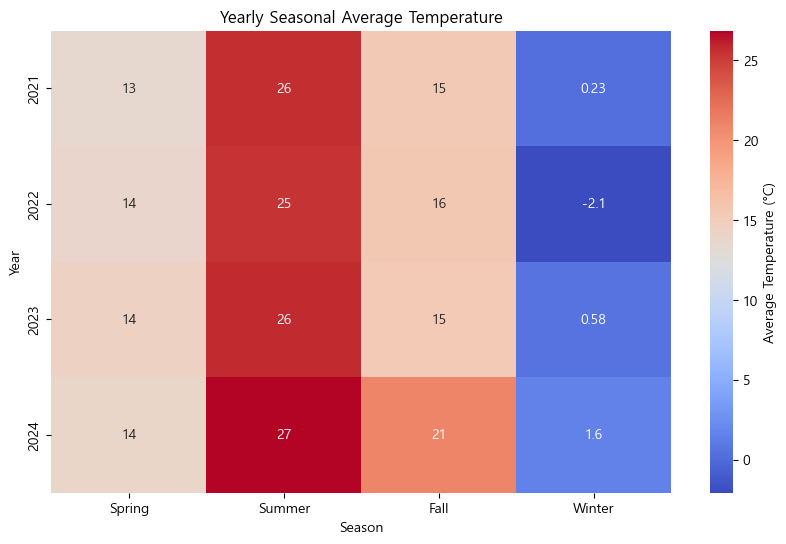

In [111]:
# 연도별/계절별 평균 기온 계산
seasonal_yearly_avg = m_df.groupby(['year', 'season'])['avg_temp'].mean().unstack()

# 시각화 (히트맵)
plt.figure(figsize=(10, 6))
sns.heatmap(seasonal_yearly_avg, annot=True, cmap='coolwarm', cbar_kws={'label': 'Average Temperature (°C)'})
plt.title('Yearly Seasonal Average Temperature')
plt.xlabel('Season')
plt.ylabel('Year')
plt.show()

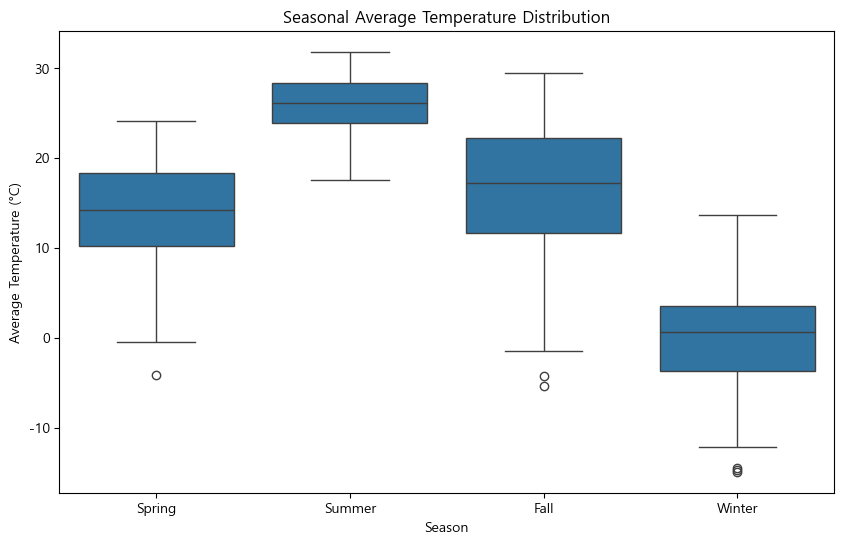

In [112]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='avg_temp', data=m_df)
plt.title('Seasonal Average Temperature Distribution')
plt.xlabel('Season')
plt.ylabel('Average Temperature (°C)')
plt.show()


C:\Users\human\AppData\Local\Temp\ipykernel_10804\702703528.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_avg_temp = m_df.groupby('season')['avg_temp'].mean()


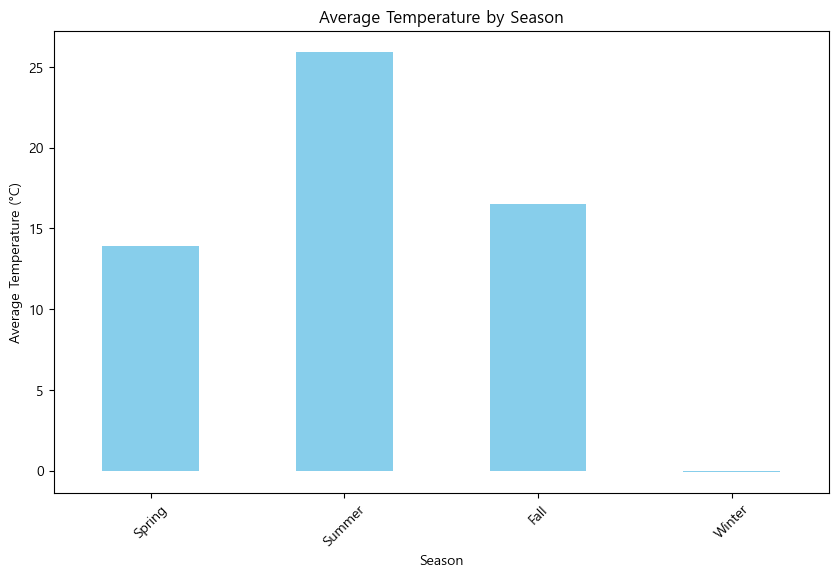

In [119]:
seasonal_avg_temp = m_df.groupby('season')['avg_temp'].mean()

plt.figure(figsize=(10, 6))
seasonal_avg_temp.plot(kind='bar', color='skyblue')
plt.title('Average Temperature by Season')
plt.xlabel('Season')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)
plt.show()


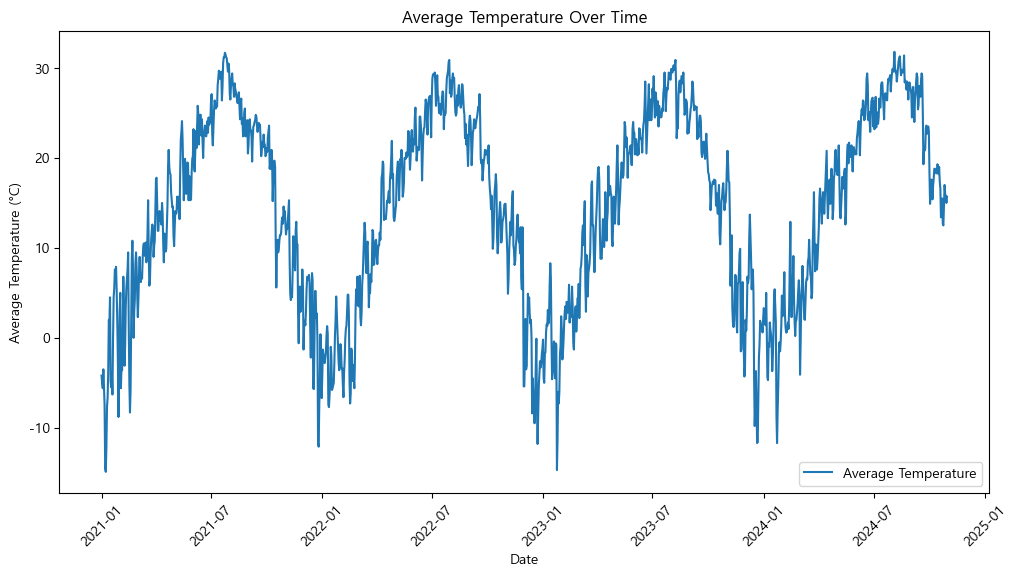

In [121]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=m_df, x='date', y='avg_temp', label='Average Temperature')
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)
plt.show()


In [122]:
m_df.to_csv('data/temperature.csv')